# Experimento 5: CNNs varios locutores

In [1]:
from os import listdir
from os.path import isdir, join
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features
from scipy.io import wavfile

### Load features

In [2]:
feature_sets_file = 'mfcc_sets_BD2.npz'
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x', 'y', 'words']

In [3]:
words = feature_sets['words']
print(words)

['zero' 'one' 'two' 'three' 'four' 'five' 'six' 'seven' 'eight' 'nine'
 'yes' 'no' 'up' 'down' 'left' 'right' 'on' 'off' 'stop' 'go']


In [4]:
x = feature_sets['x']
y = feature_sets['y']
print(x.shape)
print(y.shape)

(70608, 20, 99)
(70608,)


In [5]:
# Split MFFCC coefficients into random train, test and validation subsets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
print("Train files : ",len(x_train))
print("Test files : ", len(x_test))
print("Validation files : ", len(x_val))

Train files :  50837
Test files :  14122
Validation files :  5649


In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)
x_val = tf.keras.utils.normalize(x_val, axis=1)

In [7]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(50837, 20, 99, 1)
(5649, 20, 99, 1)
(14122, 20, 99, 1)


In [8]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(20, 99, 1)


In [9]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(words), activation='softmax'))
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 19, 98, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 49, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 48, 32)         4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 24, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 23, 64)         8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 11, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 704)               0

In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
EPOCHS = 30
history = model.fit(
    x_train, 
    y_train,  
    epochs=EPOCHS,
    batch_size=100,
    validation_data=(x_val, y_val)
)

Epoch 1/30
509/509 [==============================] - 42s 83ms/step - loss: 2.2143 - accuracy: 0.3123 - val_loss: 1.4153 - val_accuracy: 0.5771
Epoch 2/30
509/509 [==============================] - 45s 87ms/step - loss: 1.3129 - accuracy: 0.5926 - val_loss: 0.9211 - val_accuracy: 0.7230
Epoch 3/30
509/509 [==============================] - 35s 68ms/step - loss: 0.9969 - accuracy: 0.6863 - val_loss: 0.7402 - val_accuracy: 0.7764
Epoch 4/30
509/509 [==============================] - 29s 57ms/step - loss: 0.8462 - accuracy: 0.7334 - val_loss: 0.6545 - val_accuracy: 0.8003
Epoch 5/30
509/509 [==============================] - 29s 57ms/step - loss: 0.7483 - accuracy: 0.7633 - val_loss: 0.5859 - val_accuracy: 0.8147
Epoch 6/30
509/509 [==============================] - 30s 59ms/step - loss: 0.6727 - accuracy: 0.7895 - val_loss: 0.5219 - val_accuracy: 0.8378
Epoch 7/30
509/509 [==============================] - 30s 59ms/step - loss: 0.6173 - accuracy: 0.8045 - val_loss: 0.4966 - val_accuracy:

In [12]:
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 88%


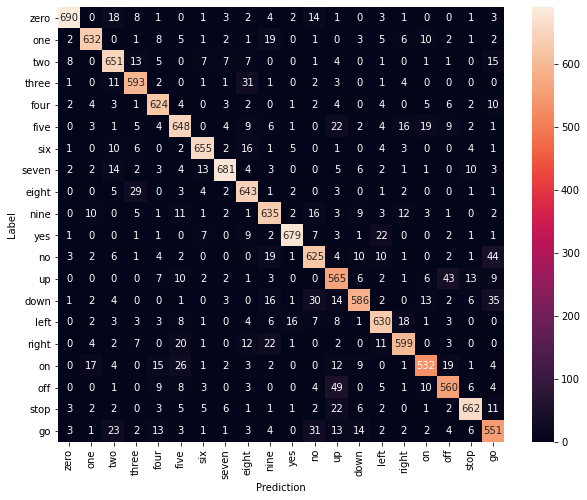

In [13]:
import seaborn as sns
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=words, yticklabels=words, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
print('Accuracy Score :',accuracy_score(y_true, y_pred)*100 )
print('Report : ')
print(classification_report(y_true, y_pred, target_names= words))

Accuracy Score : 88.09658688571024
Report : 
              precision    recall  f1-score   support

        zero       0.96      0.92      0.94       752
         one       0.93      0.90      0.91       701
         two       0.86      0.90      0.88       721
       three       0.88      0.91      0.89       651
        four       0.89      0.92      0.90       677
        five       0.85      0.86      0.85       756
         six       0.93      0.92      0.93       711
       seven       0.94      0.90      0.92       756
       eight       0.86      0.92      0.89       697
        nine       0.85      0.89      0.87       717
         yes       0.95      0.92      0.94       737
          no       0.84      0.85      0.85       735
          up       0.77      0.84      0.80       670
        down       0.90      0.82      0.86       716
        left       0.88      0.88      0.88       714
       right       0.90      0.88      0.89       684
          on       0.88      0.82   